In [53]:
#library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from keras.datasets import fashion_mnist
from keras.layers import BatchNormalization,Dense,Dropout,Flatten,Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from IPython import display


In [54]:
#Load Data
(xTrain, yTrain),(_,_) = fashion_mnist.load_data()

In [55]:
#reshape and normalise data
xTrain = xTrain.reshape(xTrain.shape[0],28,28,1).astype("float32")
xTrain = xTrain/127.5-1.0 #tanh -->[-1,1]
len(xTrain)

60000

In [56]:
batchSize = 256
trainDataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(len(xTrain)).batch(batchSize)

In [57]:
nepochs = 50
zDim = 100
imgShape = (28,28,1)
sampleInterval = 5

In [58]:
def buildGenerator():

    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_shape=(zDim,)))
    model.add(Reshape((7,7, 256)))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [59]:
buildGenerator().summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 12544)             1266944   
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_27 (Conv2D  (None, 14, 14, 128)      295040    
 Transpose)                                                      
                                                                 
 batch_normalization_22 (Bat  (None, 14, 14, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_28 (Conv2D  (None, 14, 14, 64)     

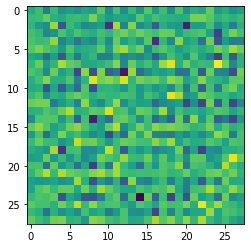

In [60]:
#generate noise image
generator = buildGenerator()

noise = tf.random.normal([1, zDim])
generatedImage = generator(noise, training=False)

plt.imshow((generatedImage[0])* 0.5 + 0.5)


In [61]:
#Discriminator
def buildDiscriminator():

    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=imgShape,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))


    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [62]:
buildDiscriminator().summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_26 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                     

In [63]:
#classyfy with discriminator
discriminator = buildDiscriminator()
decision = discriminator(generatedImage, training = False)
print (decision)

tf.Tensor([[0.49893415]], shape=(1, 1), dtype=float32)


In [64]:
crossentropy = BinaryCrossentropy(from_logits=False)

In [65]:
def discriminatorLoss(real, fake):
    realLoss = crossentropy(tf.ones_like(real), real)
    fakeLoss = crossentropy(tf.zeros_like(fake), fake)
    return realLoss + fakeLoss

In [66]:
def generatorLoss(fake):
    return crossentropy(tf.ones_like(fake), fake)

In [67]:
generatorOptimiser = tf.keras.optimizers.Adam()
discriminatorOptimiser = tf.keras.optimizers.Adam()

In [68]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batchSize, zDim])

    with tf.GradientTape() as gTape, tf.GradientTape() as dTape:
      genImg = generator(noise, training=True)

      real = discriminator(images, training=True)
      fake = discriminator(genImg, training=True)

      gLoss = generatorLoss(fake)
      dLoss = discriminatorLoss(real, fake)

    gradientsOfGenerator = gTape.gradient(gLoss, generator.trainable_variables)
    gradientsOfDiscriminator = dTape.gradient(dLoss, discriminator.trainable_variables)

    generatorOptimiser.apply_gradients(zip(gradientsOfGenerator, generator.trainable_variables))
    discriminatorOptimiser.apply_gradients(zip(gradientsOfDiscriminator, discriminator.trainable_variables))

    acc = tf.reduce_mean(100-discriminator(genImg,training=False))
    return gLoss,dLoss,acc

In [69]:
def training():
    for epoch in range(nepochs):
      start = time.time()

      for batch in trainDataset:
        train_step(batch)
        genLoss,disLoss,acc = train_step(batch)
        
      if (epoch + 1) % sampleInterval ==0:
        print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
        print("Epoch: ",epoch + 1,"| Discriminator Loss: ",np.round(tf.get_static_value(disLoss),2),"| Accuracy: ",np.round(tf.get_static_value(acc),2),"%","| Generator Loss: ",np.round(tf.get_static_value(genLoss),2))
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")
        sampleImg(generator)

In [72]:
def sampleImg(generator,imgGridRow = 5, imgGridColumn = 5):
    noise = tf.random.normal([batchSize, zDim])
    genImg = generator.predict(noise)

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(5,5),sharey = True,sharex=True)
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt]* 0.5 + 0.5,cmap="gray")
            axs[i,j].axis("off")
            cnt+=1
    plt.show()

Time for epoch 5 is 18.0 sec
Epoch:  5 | Discriminator Loss:  0.39 | Accuracy:  99.6 % | Generator Loss:  3.2
---------------------------------------------------------------------------------------------------------------------------------------------------------------


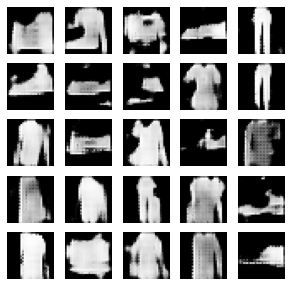

Time for epoch 10 is 18.0 sec
Epoch:  10 | Discriminator Loss:  0.31 | Accuracy:  99.61 % | Generator Loss:  5.37
---------------------------------------------------------------------------------------------------------------------------------------------------------------


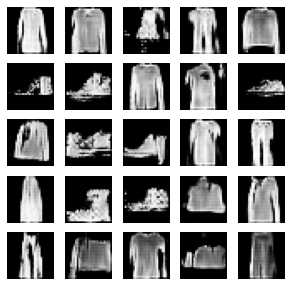

Time for epoch 15 is 18.0 sec
Epoch:  15 | Discriminator Loss:  0.47 | Accuracy:  99.73 % | Generator Loss:  2.46
---------------------------------------------------------------------------------------------------------------------------------------------------------------


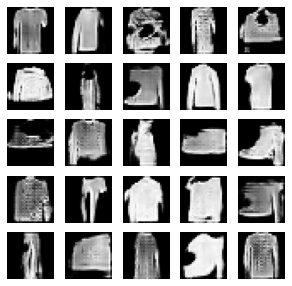

Time for epoch 20 is 18.0 sec
Epoch:  20 | Discriminator Loss:  0.48 | Accuracy:  99.59 % | Generator Loss:  2.41
---------------------------------------------------------------------------------------------------------------------------------------------------------------


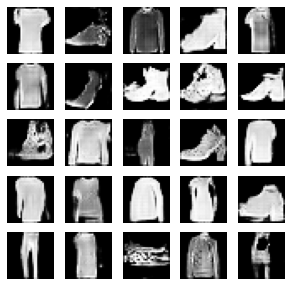

Time for epoch 25 is 18.0 sec
Epoch:  25 | Discriminator Loss:  0.76 | Accuracy:  99.54 % | Generator Loss:  2.91
---------------------------------------------------------------------------------------------------------------------------------------------------------------


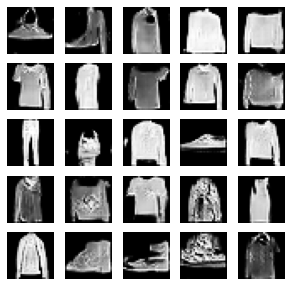

Time for epoch 30 is 18.0 sec
Epoch:  30 | Discriminator Loss:  0.62 | Accuracy:  99.63 % | Generator Loss:  2.99
---------------------------------------------------------------------------------------------------------------------------------------------------------------


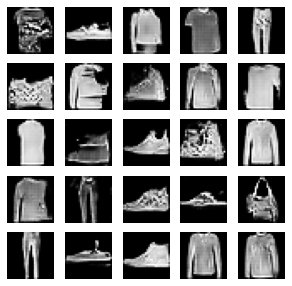

Time for epoch 35 is 18.0 sec
Epoch:  35 | Discriminator Loss:  0.63 | Accuracy:  99.71 % | Generator Loss:  1.68
---------------------------------------------------------------------------------------------------------------------------------------------------------------


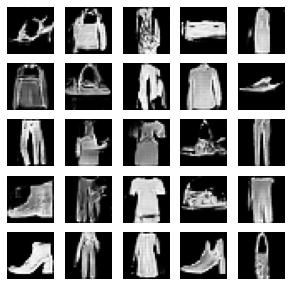

Time for epoch 40 is 18.0 sec
Epoch:  40 | Discriminator Loss:  0.69 | Accuracy:  99.61 % | Generator Loss:  2.6
---------------------------------------------------------------------------------------------------------------------------------------------------------------


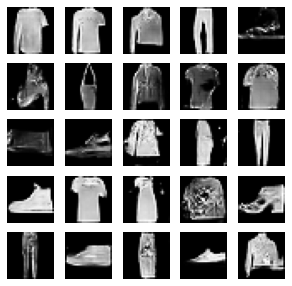

Time for epoch 45 is 18.0 sec
Epoch:  45 | Discriminator Loss:  0.48 | Accuracy:  99.51 % | Generator Loss:  2.52
---------------------------------------------------------------------------------------------------------------------------------------------------------------


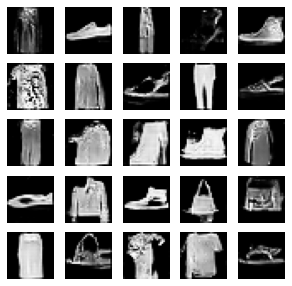

Time for epoch 50 is 18.0 sec
Epoch:  50 | Discriminator Loss:  0.67 | Accuracy:  99.68 % | Generator Loss:  3.02
---------------------------------------------------------------------------------------------------------------------------------------------------------------


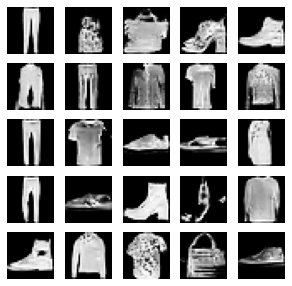

In [73]:
training()